# Data analysis

In [1]:
import os
import sys

# set the working dir to the parent working dir
current_working_dir = os.getcwd()
print(f'Previous working dir: {current_working_dir}')
new_working_dir = current_working_dir.replace('notebooks', '')
os.chdir(new_working_dir)
sys.path.insert(0, new_working_dir)
print(f'Current working dir: {os.getcwd()}')

Previous working dir: /home/albert/PycharmProjects/cat_classifier/notebooks
Current working dir: /home/albert/PycharmProjects/cat_classifier


## Load data

In [9]:
import glob
from data.utils.read_data import read_paths

data_dict = read_paths('dataset')
data, classnames = zip(*[[value, key] for key, value_list in data_dict.items() for value in value_list])
print(f'data size: {len(classnames)}')

data size: 704


## Data Imbalance
Check whether there is an inbalance in the class sizes (are there classes with way less or way more examples then the others).

#### conclusion:
- small imbalance: requires rebalancing:
    - epochs could consist of randomly picked images, using different picking for all epoch
        - Under-sampling: sample elements to train from the larger classes (it can be different for every epoch to use all examples for the whole training)
        - Over-sampling: reuse elements from the smaller classes (it should be augmented and can be different for every epoch to minimize overfitting)

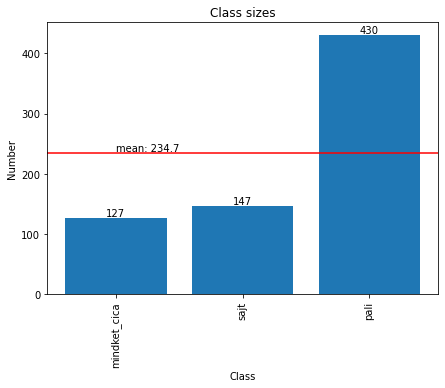

In [3]:
# show the class sizes
from data.utils.read_data import read_paths
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from data.utils.split_train_val import load_csv
import csv

with open('/home/albert/data/R-jpg/train.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

# load the data and get the class names and sizes
class_names = np.array(list(Counter(classnames).keys())) # equals to list(set(words))
class_sizes = np.array(list(Counter(classnames).values())) # counts the elements' frequency
class_sizes_mean = np.mean(class_sizes)

# sort the classes according to the class size
sorting_indices = np.argsort(class_sizes)
class_sizes = class_sizes[sorting_indices]
class_names = class_names[sorting_indices]

# plot
fig = plt.figure(figsize=[7, 5])
plt.bar(class_names, class_sizes)
plt.axhline(class_sizes_mean, color="red")
plt.text(0, class_sizes_mean, f'mean: {class_sizes_mean:.1f}', va='bottom', ha="left")
plt.xticks(rotation=90)
plt.title('Class sizes')
plt.xlabel('Class')
plt.ylabel('Number')
for i in range(len(class_sizes)):
    plt.annotate(str(class_sizes[i]), 
                 xy=(class_names[i],class_sizes[i]), 
                 ha='center', va='bottom')
plt.show()

## Balanced data sizes


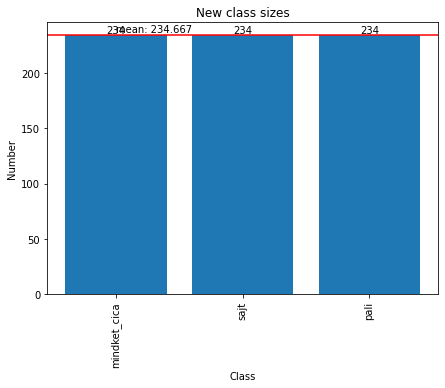

In [4]:
class_sizes_rates = [min(10, class_sizes_mean/class_size) for class_size in class_sizes]
new_class_sizes = [int(class_size_rate*class_size) 
                   for class_size_rate, class_size in zip(class_sizes_rates, class_sizes)]

# plot
fig = plt.figure(figsize=[7, 5])
plt.bar(class_names, new_class_sizes)
plt.axhline(class_sizes_mean, color="red")
plt.text(0, class_sizes_mean, f'mean: {class_sizes_mean:.3f}', va='bottom', ha="left")
plt.xticks(rotation=90)
plt.title('New class sizes')
plt.xlabel('Class')
plt.ylabel('Number')
for i in range(len(new_class_sizes)):
    plt.annotate(str(new_class_sizes[i]), 
                 xy=(class_names[i],new_class_sizes[i]), 
                 ha='center', va='bottom')
plt.show()

## Mean and std 

Calculate the mean and the std of the images for normalizing

In [5]:
import torchvision.transforms.functional as F
from PIL import Image

datapaths = list(zip(*data))[0]


mean = 0.
std = 0.
nb_samples = 0.
for datapath in datapaths:
    with Image.open(datapath) as im:
        image = F.to_tensor(im)
    mean += image.mean([1, 2])
    std += image.std([1, 2])
    nb_samples += 1

mean /= nb_samples
std /= nb_samples
print(f'mean: {mean}, std: {std}')

mean: tensor([0.4432, 0.3938, 0.3764]), std: tensor([0.1560, 0.1815, 0.1727])


## Check the resolution of the images
If all the images have the same resolution then we are lucky, we do not have to resize to make batches.
If we are less lucky, but have the same aspect ratio, then we are still a little lucky, because by resizing we wont squeeze it.
Although if the aspect ratio is not 1:1, then we have to either crop or resize to be able to have rotated elements in one batch.

#### conclusion: 
- there are photos where the cat is straight or rotated to one direction
- also there are photos which are in lanscape mode (the vast majority) and some that are standing (a few): (these could be rotated to landscape), as we will rotate, crop and resize to square format (for batches), it is not required to deal with these separately

heights: [562, 750, 1000, 751] with numbers: [1, 697, 5, 1]
widths: [1000, 751, 749, 563] with numbers: [701, 1, 1, 1]

sus height: ['dataset/pali/Share2015-08-27-a2a529267de7618265623c7ba18c659b6470af025e91f6b00fc0b8161e4e839d-Picture.jpg', 'dataset/pali/WP_20150828_007.jpg', 'dataset/pali/MQZJ4928.JPG', 'dataset/pali/IMG_0834.JPG', 'dataset/mindket_cica/IMG_1066.JPG', 'dataset/mindket_cica/IMG_1559.JPG', 'dataset/sajt/IMG_0927.JPG']

suss width: ['dataset/pali/WP_20150828_007.jpg', 'dataset/pali/MQZJ4928.JPG', 'dataset/sajt/IMG_0927.JPG']

sus both height and width: ['dataset/pali/WP_20150828_007.jpg', 'dataset/sajt/IMG_0927.JPG', 'dataset/pali/MQZJ4928.JPG']

size: 562x1000


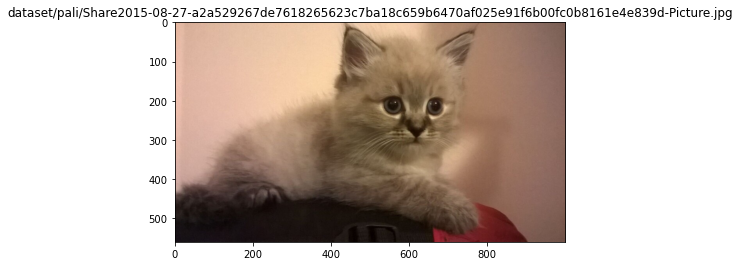

size: 1000x751


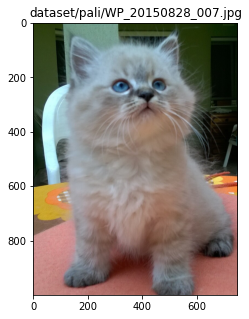

size: 1000x749


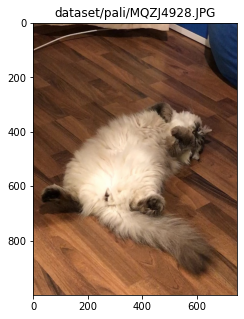

size: 1000x1000


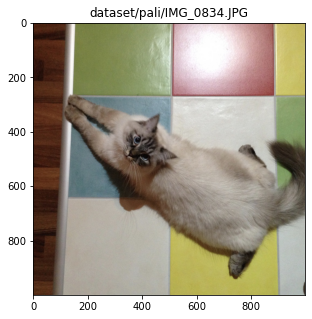

size: 1000x1000


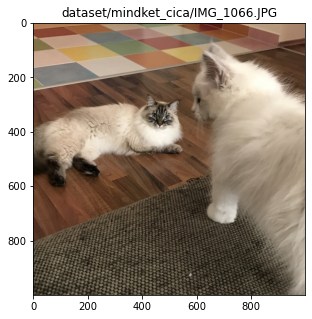

size: 751x1000


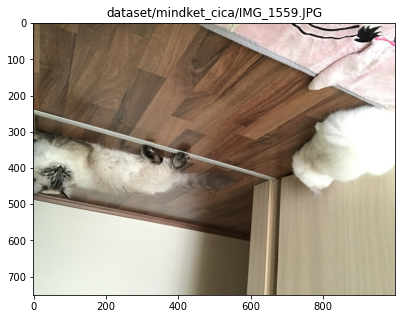

size: 1000x563


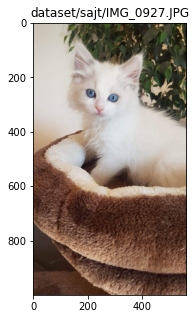

size: 1000x751


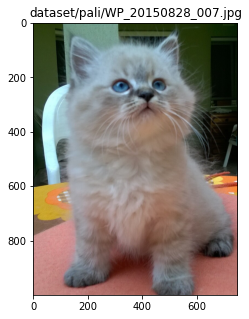

size: 1000x749


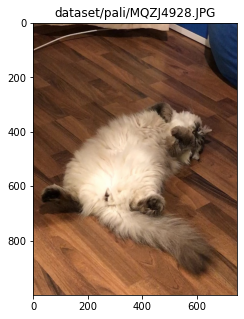

size: 1000x563


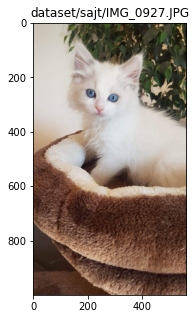

In [13]:
import numpy as np

heights, widths, asp_ratio = [], [], []
sus = {'height': [], 'width': []}
for element in data:
    # read the image and run the inference for detections
    image = Image.open(element)
    heights.append(image.size[1])
    widths.append(image.size[0])
    asp_ratio.append(image.size[0]/image.size[1])
    if image.size[1] != 750:
        sus['height'].append(element)
    if image.size[0] != 1000:
        sus['width'].append(element)

uniques = list(Counter(heights).keys())
unique_numbers = list(Counter(heights).values())
print(f'heights: {uniques} with numbers: {unique_numbers}')

uniques = list(Counter(widths).keys())
unique_numbers = list(Counter(widths).values())
print(f'widths: {uniques} with numbers: {unique_numbers}')

print(f'\nsus height: {sus["height"]}\n')
print(f'suss width: {sus["width"]}\n')
print(f'sus both height and width: {list(set(sus["height"]) & set(sus["width"]))}\n')

for curr_class, elements in sus.items():
    for element in elements:
        # read the image and run the inference for detections
        image = Image.open(element)
        print(f'size: {image.size[1]}x{image.size[0]}')
        plt.figure(figsize=[7, 5])
        plt.title(element)
        plt.imshow(image)
        plt.show()

## Cat number calculation

The method could be split into a cat proposal and a cat prediction stage like a faster RCNN. The proposal stage (as we do not have OD labels) could be trained by an already existing OD network, then after training the whole it clould be self-trained in the next rould by a previous network.

Also, as the images contain close up and far away images from cats, it is easy to randomly cut out parts from the images  as augmentation that does not contain cats at all. These could lead to overfitting. A sub-network could be used for deciding whether a cut out image contains or does not contain cat. (Or controlling the crop to contain cats where the subnetwork is sure about the cat's location)

In [194]:
import cv2
import torch
import torchvision.transforms as transforms

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def draw_boxes(boxes, classes, labels, image):
    image = np.asarray(image)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image

    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
#     print(pred_scores)
    # get all the predicited class names
    labels = [i for score, i in zip(pred_scores, outputs[0]['labels'].cpu().numpy()) if
              score >= detection_threshold]
    pred_classes = [coco_names[i] for i in labels]

    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    
    return boxes, pred_classes, labels

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

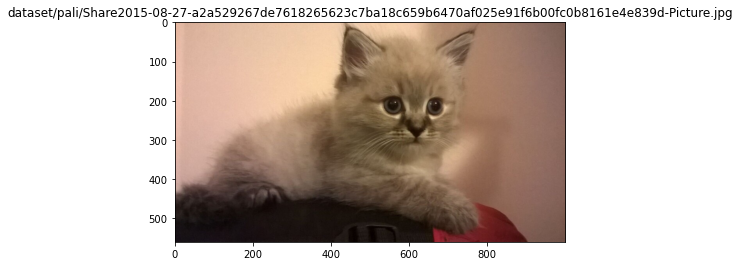

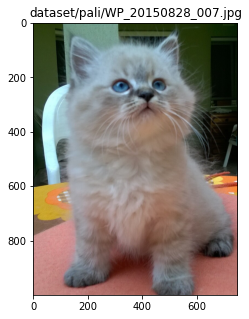

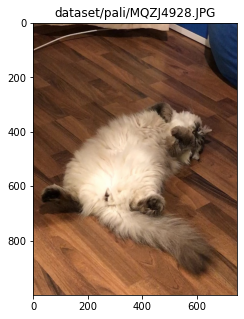

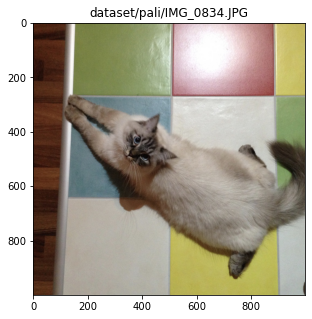

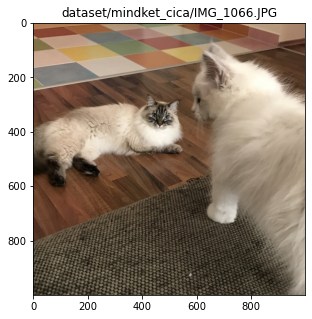

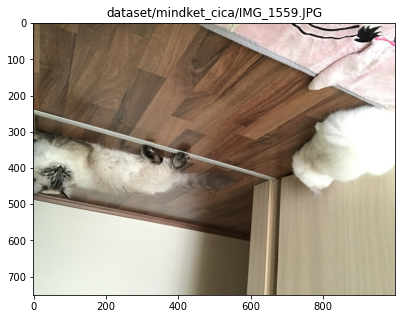

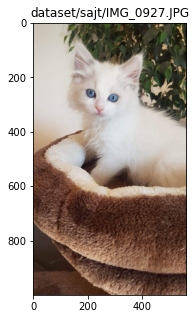

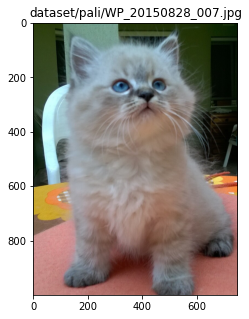

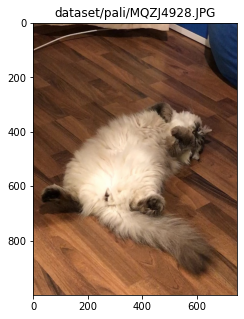

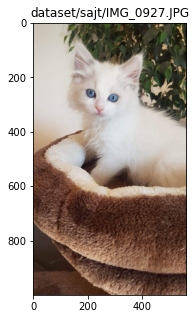

In [196]:
# for curr_class, elements in sus.items():
#     for element in elements:
#         # read the image and run the inference for detections
#         image = Image.open(element)
        
#         plt.figure(figsize=[7, 5])
#         plt.title(element)
#         plt.imshow(image)
#         plt.show()

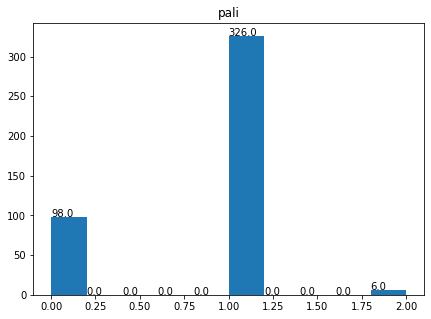

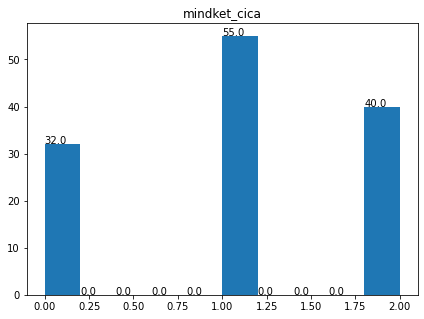

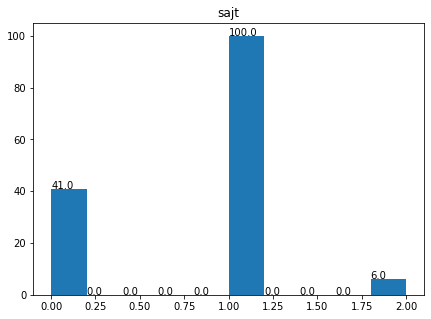

In [209]:
import torchvision
from PIL import Image
from IPython.display import clear_output

# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# load the model on to the computation device
model.eval().to(device)

sus = {key: [] for key in data_dict.keys()}

for curr_class, elements in data_dict.items():
    cat_numbers_in_class = []
    for i, element in enumerate(elements):
        # read the image and run the inference for detections
        image = Image.open(element)
        boxes, classes, labels = predict(image, model, device, 0.9)
        cat_numbers_in_class.append(classes.count('cat'))
        if curr_class == 'mindket_cica' and cat_numbers_in_class != 2:
            sus[curr_class].append(element)
        elif cat_numbers_in_class != 1:
            sus[curr_class].append(element)

    plt.figure(figsize=[7, 5])
    n, bins, patches = plt.hist(cat_numbers_in_class)
    plt.title(curr_class)
    for bar, height in zip(bins, n):
        plt.text(bar, height + .002, f'{height}')
    plt.show()
    
    
image = draw_boxes(boxes, classes, labels, image)

## Orientation
There are many images with different orientation.

#### conclusion:
- could be manually rotated to be all standing
    - lot of work
    - would not be able to be used on not standing image
- using rotation data augmentation (learning cats stand, right/left and upside down)
    - could even make the model more robust
- the images should be first cropped then resized to square form

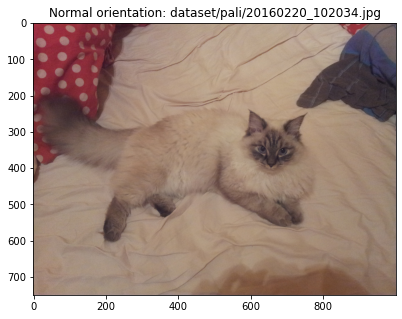

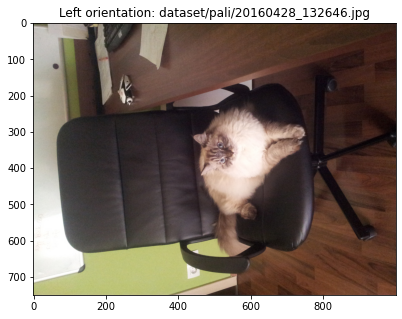

In [112]:
normal_image = 'dataset/pali/20160220_102034.jpg'
image = Image.open(normal_image)
plt.figure(figsize=[7, 5])
plt.title(f'Normal orientation: {normal_image}')
plt.imshow(image)
plt.show()

left_image = 'dataset/pali/20160428_132646.jpg'
image = Image.open(left_image)
plt.figure(figsize=[7, 5])
plt.title(f'Left orientation: {left_image}')
plt.imshow(image)
plt.show()

## Mislabelled images
- Checking all the images manually I found a few mislabelled images


- labelled `pali` although should be `mindket_cica`
    
dataset/pali/IMG_2656.JPG,
dataset/pali/IMG_2657.JPG,
dataset/pali/IMG_2658.JPG,
dataset/pali/IMG_2659.JPG,
dataset/pali/IMG_2660.JPG,
dataset/pali/IMG_2662.JPG,
dataset/pali/IMG_2668.JPG,
dataset/pali/IMG_2669.JPG

- labelled `sajt` although should be `mindket_cica`

dataset/sajt/IMG_1075.JPG
dataset/sajt/IMG_1076.JPG
dataset/sajt/IMG_1137.JPG
dataset/sajt/IMG_1943.JPG
dataset/sajt/IMG_1944.JPG
dataset/sajt/IMG_1957.JPG
dataset/sajt/IMG_1958.JPG
dataset/sajt/IMG_1959.JPG
dataset/sajt/IMG_2826.JPG
dataset/sajt/IMG_2865.JPG
dataset/sajt/IMG_3085.JPG
dataset/sajt/IMG_3086.JPG

#### conclusion: 
- these should be in the right folder: 
    - during making the train-val csv we should write them with the right label


Labelled as `pali` but contains `mindketto cica`.


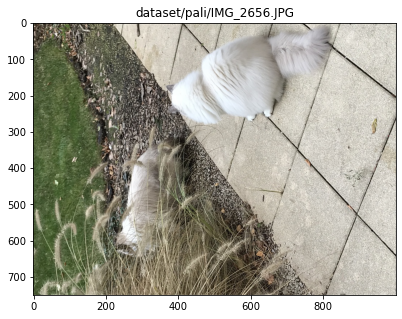

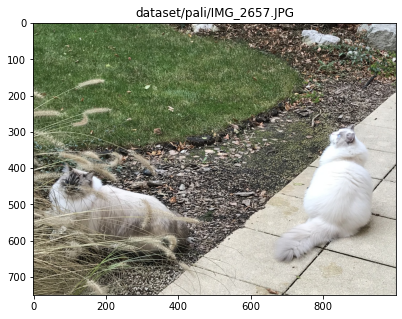

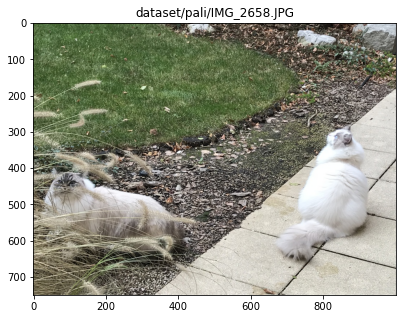

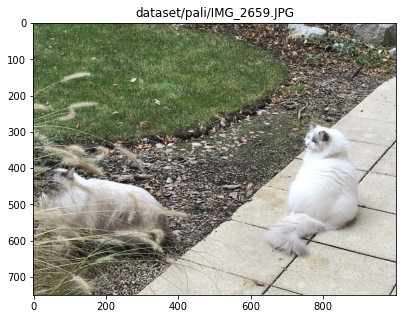

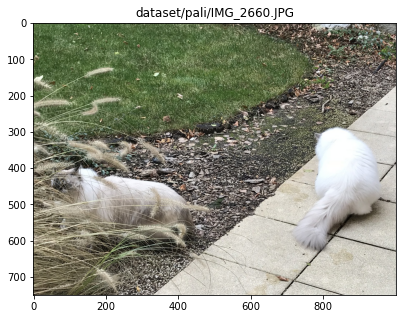

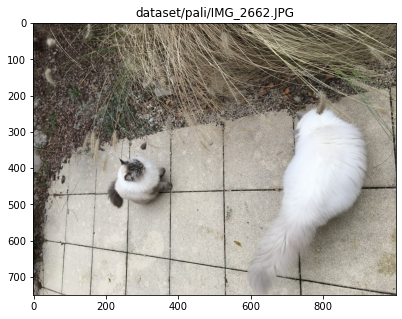

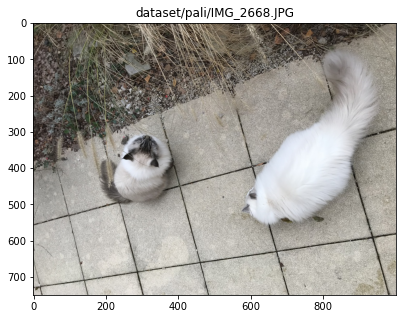

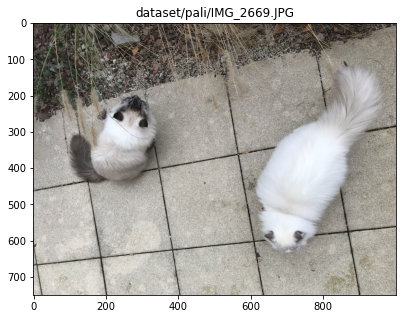

In [203]:
mislabelled_images = ['dataset/pali/IMG_2656.JPG', 
                      'dataset/pali/IMG_2657.JPG', 
                      'dataset/pali/IMG_2658.JPG', 
                      'dataset/pali/IMG_2659.JPG', 
                      'dataset/pali/IMG_2660.JPG',
                      'dataset/pali/IMG_2662.JPG', 
                      'dataset/pali/IMG_2668.JPG', 
                      'dataset/pali/IMG_2669.JPG']
print(f'Labelled as `pali` but contains `mindketto cica`.')
for mislabelled_image in mislabelled_images:
    image = Image.open(mislabelled_image)
    plt.figure(figsize=[7, 5])
    plt.title(mislabelled_image)
    plt.imshow(image)
    plt.show()

Labelled as `sajt` but contains `mindketto cica`.


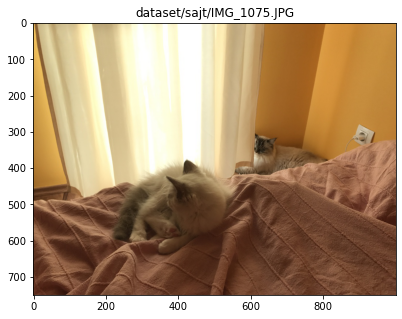

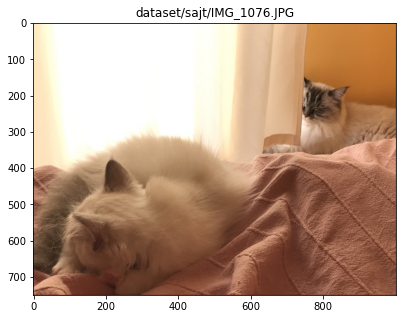

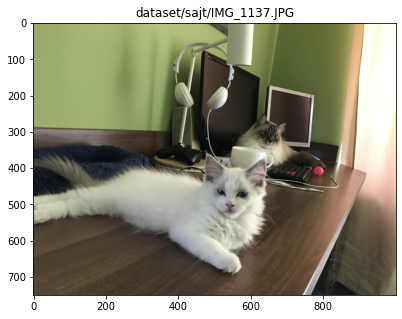

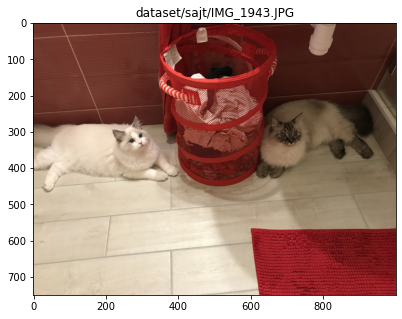

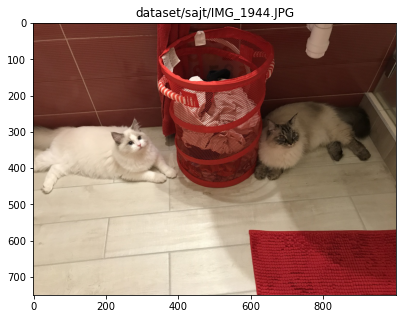

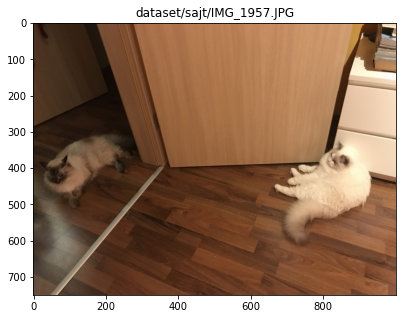

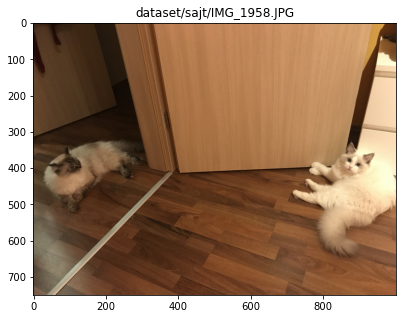

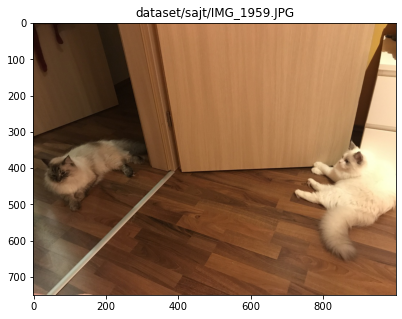

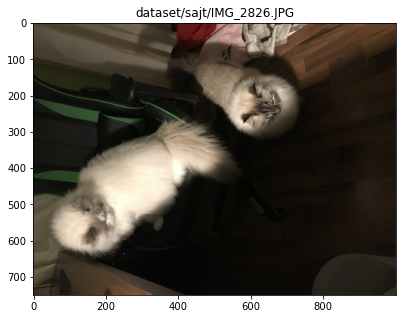

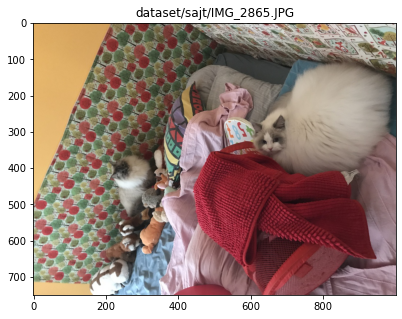

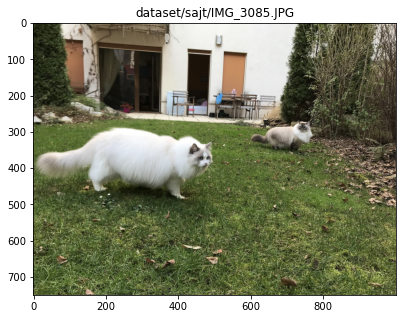

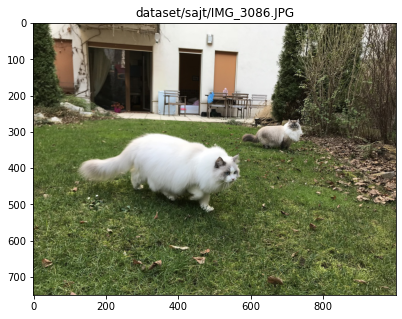

In [204]:
mislabelled_images = ['dataset/sajt/IMG_1075.JPG', 
                      'dataset/sajt/IMG_1076.JPG', 
                      'dataset/sajt/IMG_1137.JPG', 
                      'dataset/sajt/IMG_1943.JPG', 
                      'dataset/sajt/IMG_1944.JPG', 
                      'dataset/sajt/IMG_1957.JPG', 
                      'dataset/sajt/IMG_1958.JPG', 
                      'dataset/sajt/IMG_1959.JPG', 
                      'dataset/sajt/IMG_2826.JPG', 
                      'dataset/sajt/IMG_2865.JPG', 
                      'dataset/sajt/IMG_3085.JPG', 
                      'dataset/sajt/IMG_3086.JPG']
print(f'Labelled as `sajt` but contains `mindketto cica`.')
for mislabelled_image in mislabelled_images:
    image = Image.open(mislabelled_image)
    plt.figure(figsize=[7, 5])
    plt.title(mislabelled_image)
    plt.imshow(image)
    plt.show()

## Cat number in the images

- `pali` and `sajt` always contain only 1 cat, `mindket_cica` always contain 2 cats
- there are no other cats than `sajt` and `pali`
- there are no mirrors/puddles with reflections of cats (only 1 `sajt` or 1 `pali` in one image)

#### conclusion: 
- we can treat these as 3 distinct classes:
    - no need for multilabel classification
    - probably better results
        - it is easier to recognize whether there is 1 or 2 cats in the image and differentiate the 2 cats
    - we could even make a 2 stage model: 
        - one model for deciding whether there are 1 or 2 cats (merging `sajt` and `pali` together will cause bigger imbalance)
        - one model for differentiating `sajt` and `pali`
- if we want out model to work on scenes with new cats or mirrors we should stick with multilabel classification

## Cat positions

There are images of the cats really close, and images far. 

#### conclusion:
- during cropping in order to simulate close images we need to make small crops
    - if we make small crops then it is not guaranteed that the crops will contain a cat
        - a subnetwork could be used for detecting cats
            - only crops that contain cats (either the only one or both) should be used

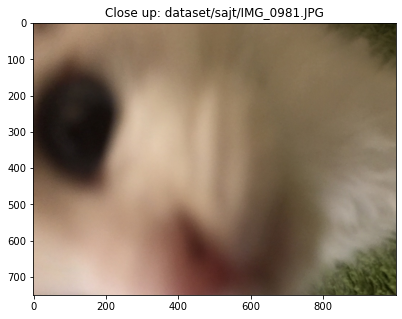

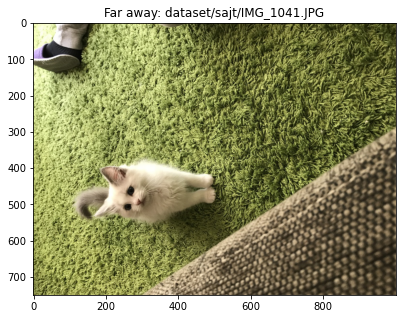

In [201]:
image_path = 'dataset/sajt/IMG_0981.JPG'
image = Image.open(image_path)
plt.figure(figsize=[7, 5])
plt.title(f'Close up: {image_path}')
plt.imshow(image)
plt.show()

image_path = 'dataset/sajt/IMG_1041.JPG'
image = Image.open(image_path)
plt.figure(figsize=[7, 5])
plt.title(f'Far away: {image_path}')
plt.imshow(image)
plt.show()